include_top=True: Use when you want a ready-to-use classification model with the original output layer for the same number of classes as the pretrained model.
include_top=False: Use when you want to modify the architecture (add your own layers) or use the model for feature extraction in a different classification task.

In [2]:
import os
import cv2
import numpy as np
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

# Define constants
data_path = "/Users/yanthraa/Desktop/PROJECT/NEW DATASET/archive"
target_size = (224, 224)
target_count = 1000  # Desired number of images per class
output_path = "/Users/yanthraa/Desktop/PROJECT/NEW DATASET/Augmented_Dataset"  # Output directory

# Ensure output directories exist
os.makedirs(output_path, exist_ok=True)
for class_name in ['Negatives', 'Positives']:
    os.makedirs(os.path.join(output_path, class_name), exist_ok=True)

# Define augmentation sequence
augmenters = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Affine(rotate=(-15, 15)),  # Rotate between -15 and 15 degrees
    iaa.GaussianBlur(sigma=(0.0, 1.0)),  # Apply Gaussian blur
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add noise
    iaa.Multiply((0.8, 1.2))  # Brightness adjustments
])

# Load and preprocess data
images = []
labels = []

for class_name in ['Negatives', 'Positives']:
    class_path = os.path.join(data_path, class_name)
    class_images = []
    label = 0 if class_name == 'Negatives' else 1
    
    # Load original images
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, target_size)
        img = img.astype(np.float32) / 255.0
        class_images.append(img)
    
    # Augment images until target count is reached
    while len(class_images) < target_count:
        augmented_images = augmenters(images=class_images[:min(len(class_images), target_count - len(class_images))])
        class_images.extend(augmented_images)
    
    class_images = class_images[:target_count]  # Trim excess
    images.extend(class_images)
    labels.extend([label] * target_count)
    
    # Save augmented images
    for idx, img in enumerate(class_images):
        save_path = os.path.join(output_path, class_name, f"aug_{idx}.png")
        cv2.imwrite(save_path, (img * 255).astype(np.uint8))

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Print class proportions
print("Class Proportions:")
print("Negatives:", np.sum(labels == 0), "Positives:", np.sum(labels == 1))


Class Proportions:
Negatives: 1000 Positives: 1000


In [3]:
from sklearn.model_selection import train_test_split

# Separate data for Negatives and Positives classes
Negatives_images = images[labels == 0][:500]
Positives_images = images[labels == 1][:500]
Negatives_labels = labels[labels == 0][:500]
Positives_labels = labels[labels == 1][:500]

# Concatenate the data back together
balanced_images = np.concatenate([Negatives_images, Positives_images])
balanced_labels = np.concatenate([Negatives_labels, Positives_labels])


# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

#print the balanced data
print("Balanced Images:",balanced_images.shape)
print("Balanced labels:",balanced_labels.shape)

#print the data seperately of each class
print("Negatives_images:",Negatives_images.shape)
print("Positives_images:",Positives_images.shape)


# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Balanced Images: (1000, 224, 224)
Balanced labels: (1000,)
Negatives_images: (500, 224, 224)
Positives_images: (500, 224, 224)
X_train shape: (720, 224, 224)
X_test shape: (200, 224, 224)
y_train shape: (720,)
y_test shape: (200,)


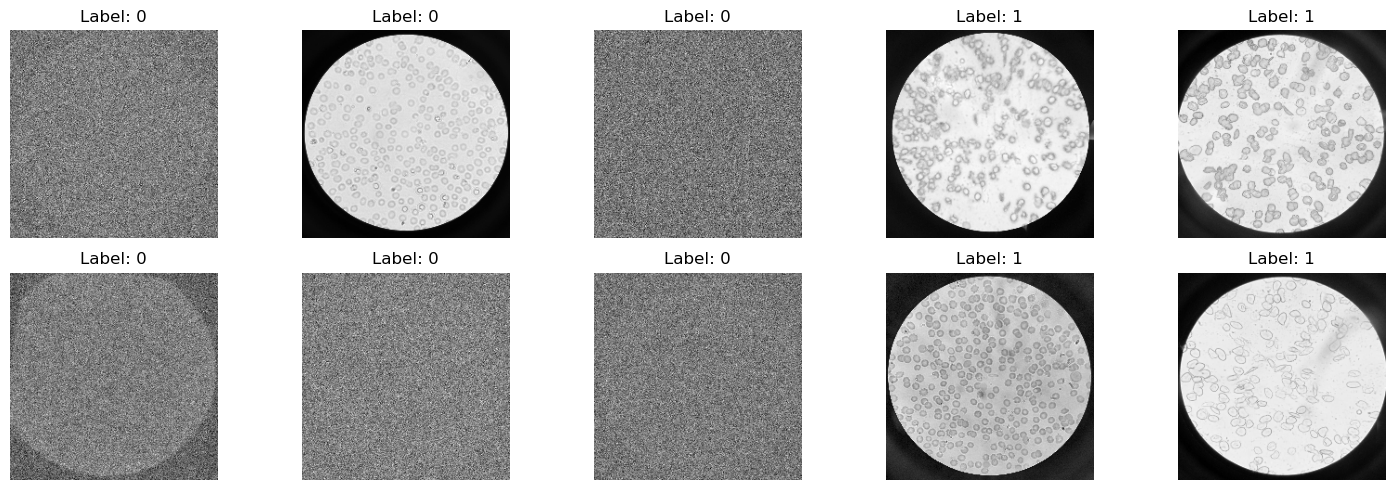

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Define the number of images to display
num_images_to_display = 10

# Select random indices for the images
indices = random.sample(range(len(balanced_images)), num_images_to_display)

# Create a figure to display the images
plt.figure(figsize=(15, 5))

# Loop over the selected indices and display the images
for i, idx in enumerate(indices):
    # Get the image and its corresareponding label
    image = balanced_images[idx]
    label = balanced_labels[idx]

    # Add a subplot for the current image
    plt.subplot(2, 5, i % 5 + 1 + (i // 5) * 5)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()

# CNN

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,977,185 (22.80 MB)

 Trainable params: 5,977,185 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 362ms/step - accuracy: 0.5269 - auc: 0.5977 - auc_1: 0.5289 - false_negatives: 154.1250 - false_positives: 32.4167 - loss: 33.1967 - precision: 0.5026 - recall: 0.2433 - true_negatives: 172.5000 - true_positives: 38.2917 - val_accuracy: 0.5300 - val_auc: 0.2562 - val_auc_1: 0.3909 - val_false_negatives: 0.0000e+00 - val_false_positives: 94.0000 - val_loss: 1.0393 - val_precision: 0.5253 - val_recall: 1.0000 - val_true_negatives: 2.0000 - val_true_positives: 104.0000
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.6729 - auc: 0.6279 - auc_1: 0.5407 - false_negatives: 16.7500 - false_positives: 98.4167 - loss: 0.7155 - precision: 0.6166 - recall: 0.9360 - true_negatives: 103.4583 - true_positives: 178.7083 - val_accuracy: 0.7700 - val_auc: 0.7892 - val_auc_1: 0.7745 - val_false_negatives: 18.0000 - val_false_positives: 28.0000 - val_loss: 0.6129 - val_precision: 0.7544 - val_recall: 0.8269 - val_true_negatives: 68.0000 - val_tru

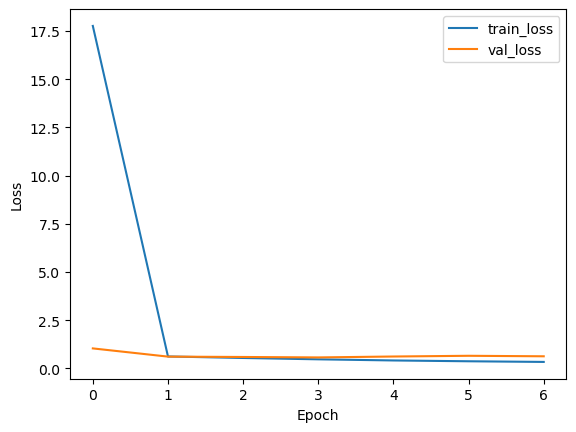

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.7629 - auc: 0.7976 - auc_1: 0.8068 - false_negatives: 11.6250 - false_positives: 19.6250 - loss: 0.5676 - precision: 0.7538 - recall: 0.8332 - true_negatives: 43.3750 - true_positives: 59.3750
Test Accuracy: 77.50%
Precision: 0.76
Recall: 0.84
AUC-ROC: 0.80
AUC-PR: 0.79
TN: 68.0, FP: 28.0, FN: 17.0, TP: 87.0
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Confusion Matrix:
[[68 28]
 [17 87]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        96
           1       0.76      0.84      0.79       104

    accuracy                           0.78       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.78      0.77       200

AUC Score: 0.77
Precision: 0.76
Recall: 0.84
F1 Score: 0.79
PR AUC: 0.84
Cohen's Kappa Coefficient: 0.55
Matthews Correlation Coefficient (MCC): 0.55
Balanced Accuracy: 0.77
Specificity: 0.71
Jaccard Index: 0.66


In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, f1_score, balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef, jaccard_score
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import time
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import directed_hausdorff

# Start time
start_time = time.time()

# Assume X_train and y_train are the original splits

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.expand_dims(X_train_resized, axis=-1)  # Add channel dimension
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of the CNN

# Example: Assuming X_test is another dataset
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Define CNN architecture

model = Sequential([
    # First convolutional layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 16 filters, 3x3 kernel
    MaxPooling2D((2, 2)),  # Downsample to 112x112
    # Second convolutional layer
    Conv2D(32, (3, 3), activation='relu'),  # 32 filters, 3x3 kernel
    MaxPooling2D((2, 2)),  # Downsample to 56x56
    # Flatten the output to feed into fully connected layers
    Flatten(),
    # Fully connected layer
    Dense(64, activation='relu'),  # 64 units
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', 
                                                                      tf.keras.metrics.Precision(),
                                                                      tf.keras.metrics.Recall(),
                                                                      tf.keras.metrics.AUC(),
                                                                      tf.keras.metrics.AUC(curve='PR'),
                                                                      tf.keras.metrics.TrueNegatives(),
                                                                      tf.keras.metrics.FalsePositives(),
                                                                      tf.keras.metrics.FalseNegatives(),
                                                                      tf.keras.metrics.TruePositives()])

# Display model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model with early stopping and 50 epochs
history = model.fit(X_train_resized, y_train, epochs=50, validation_data=(X_test_resized, y_test), callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy, precision_val, recall_val, auc_roc, auc_pr, tn, fp, fn, tp = model.evaluate(X_test_resized, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'AUC-ROC: {auc_roc:.2f}')
print(f'AUC-PR: {auc_pr:.2f}')
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

# Confusion matrix
test_predictions = (model.predict(X_test_resized) > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_predictions)
print(f'AUC Score: {roc_auc:.2f}')

# Precision for class 1 (Positive)
precision = precision_score(y_test, test_predictions)
print(f'Precision: {precision:.2f}')

# Recall for class 1 (Positive)
recall = recall_score(y_test, test_predictions)
print(f'Recall: {recall:.2f}')

# F1 Score
f1 = f1_score(y_test, test_predictions)
print(f'F1 Score: {f1:.2f}')

# Precision-Recall curve and PR AUC
precision, recall, _ = precision_recall_curve(y_test, test_predictions)
pr_auc = auc(recall, precision)
print(f'PR AUC: {pr_auc:.2f}')

# Cohen's Kappa Coefficient
kappa = cohen_kappa_score(y_test, test_predictions)
print(f"Cohen's Kappa Coefficient: {kappa:.2f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, test_predictions)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, test_predictions)
print(f"Balanced Accuracy: {balanced_acc:.2f}")

# Specificity: TN / (TN + FP)
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.2f}")

# Jaccard Index (IoU for binary classification)
jaccard_idx = jaccard_score(y_test, test_predictions)
print(f'Jaccard Index: {jaccard_idx:.2f}')

# Dice Coefficient
def dice_coefficient(tp, fp, fn):
    return 2 * tp / (2 * tp + fp + fn)

dice_coef = dice_coefficient(tp, fp, fn)
print(f'Dice Coefficient: {dice_coef:.2f}')


# Modified SSIM calculation for binary classification
def calculate_binary_ssim(y_true, y_pred):
    """
    Calculate SSIM for binary classification results.
    Converts predictions and ground truth to image-like format before comparison.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
    
    Returns:
        float: Average SSIM value
    """
    # Convert binary vectors to 2D arrays if they're 1D
    if y_true.ndim == 1:
        # Reshape to a square-like 2D array
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))
        
        # Fill the arrays with actual values
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred
        
        # Calculate SSIM
        ssim_value = ssim(y_true_2d, y_pred_2d, data_range=1.0)
        
        return ssim_value
    else:
        # If input is already multi-dimensional, calculate SSIM directly
        return ssim(y_true, y_pred, data_range=1.0)

# Calculate SSIM with the corrected function
try:
    ssim_value = calculate_binary_ssim(y_test, test_predictions)
    print(f'SSIM: {ssim_value:.2f}')
except Exception as e:
    print(f"Could not calculate SSIM: {str(e)}")
    ssim_value = None

def calculate_hausdorff_distance(y_true, y_pred):
    """
    Calculate Hausdorff Distance for binary classification results.
    Converts predictions and ground truth to image-like 2D arrays before comparison.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels

    Returns:
        float: Hausdorff distance
    """
    if y_true.ndim == 1:
        # Reshape 1D arrays into square-like 2D arrays
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))

        # Fill the 2D arrays with the binary values
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred

        # Calculate Hausdorff distance between 2D binary masks
        return directed_hausdorff(y_true_2d, y_pred_2d)[0]
    else:
        # Directly calculate Hausdorff distance if input is already multi-dimensional
        return directed_hausdorff(y_true, y_pred)[0]

# Now calculate the Hausdorff distance with the corrected function
hausdorff_distance = calculate_hausdorff_distance(y_test, test_predictions)
print(f'Hausdorff Distance: {hausdorff_distance:.2f}')



# End time
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")
# Calculate time taken
time_taken = end_time - start_time

metrics_dict = {
    'Test Accuracy': [test_accuracy],
    'Train Accuracy': [history.history['accuracy'][-1] if 'accuracy' in history.history else None],
    'Precision': [precision_val],
    'Recall': [recall_val],
    'AUC-ROC': [auc_roc],
    'AUC-PR': [auc_pr],
    'TN': [tn],
    'FP': [fp],
    'FN': [fn],
    'TP': [tp],
    'AUC Score': [roc_auc],
    'F1 Score': [f1],
    'PR AUC': [pr_auc],
    'Cohen\'s Kappa Coefficient': [kappa],
    'Matthews Correlation Coefficient': [mcc],
    'Training Loss': [history.history['loss'][-1] if 'loss' in history.history else None],
    'Testing Loss': [test_loss],
    'Time Taken (seconds)': [time_taken]  # Added time taken metric
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Save the DataFrame to an Excel file
file_name = 'Simplified_CNN_Metrics.csv'
metrics_df.to_csv(file_name, index=False)

print(f'Metrics saved to {file_name}')

# DenseNet121

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6854 - auc_4: 0.7224 - auc_5: 0.6718 - false_negatives_2: 51.7826 - false_positives_2: 54.2826 - loss: 0.7866 - precision_2: 0.6947 - recall_2: 0.7000 - true_negatives_2: 135.0435 - true_positives_2: 134.5435 - val_accuracy: 0.8450 - val_auc_4: 0.8880 - val_auc_5: 0.9276 - val_false_negatives_2: 17.0000 - val_false_positives_2: 14.0000 - val_loss: 0.4035 - val_precision_2: 0.8614 - val_recall_2: 0.8365 - val_true_negatives_2: 82.0000 - val_true_positives_2: 87.0000
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8559 - auc_4: 0.8816 - auc_5: 0.9032 - false_negatives_2: 36.7391 - false_positives_2: 21.5000 - loss: 0.4234 - precision_2: 0.8755 - recall_2: 0.8100 - true_negatives_2: 171.8913 - true_positives_2: 145.5217 - val_accuracy: 0.8200 - val_auc_4: 0.8843 - val_auc_5: 0.9284 - val_false_negatives_2: 17.0000 - val_false_positives_2: 19.0000 - val_loss: 0.4018 - val_precision_2: 0.8208 - val_recall_2: 0.8

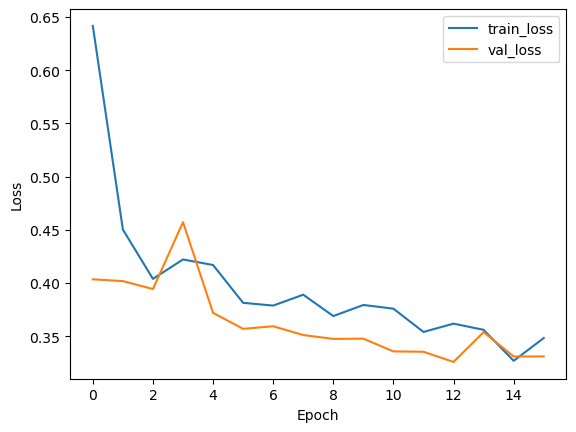

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8717 - auc_4: 0.9148 - auc_5: 0.9469 - false_negatives_2: 12.0000 - false_positives_2: 4.8750 - loss: 0.3155 - precision_2: 0.9256 - recall_2: 0.8296 - true_negatives_2: 58.1250 - true_positives_2: 59.0000
Test Accuracy: 87.50%
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Confusion Matrix:
[[89  7]
 [18 86]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        96
           1       0.92      0.83      0.87       104

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.88      0.88      0.87       200

AUC Score: 0.88
Hausdorff Distance: 2.00
SSIM: 0.74

Precision: 0.9247311827956989
Recall: 0.8269230769230769
F1 Score: 0.8730964467005076
Cohen's Kappa Coefficient: 0.7506980454726765
Matthews Correlation Coefficient: 0.7552556121842
Balanced Accuracy: 0.8770032051282051
Dice Coefficient: 0.8730

In [14]:
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score, jaccard_score
import cv2
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from skimage.metrics import structural_similarity as ssim

# Start time
start_time = time.time()

# Assume X_train, X_test, y_train, y_test are available

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.expand_dims(X_train_resized, axis=-1)  # Add channel dimension
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)  # Repeat channel dimension to match DenseNet

X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Load pre-trained DenseNet121 model without the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Compile the full model with Adam optimizer and additional metrics
model_densenet121 = Model(inputs=base_model.input, outputs=output)
model_densenet121.compile(optimizer=Adam(), 
                          loss='binary_crossentropy', 
                          metrics=['accuracy', 
                                   tf.keras.metrics.Precision(), 
                                   tf.keras.metrics.Recall(), 
                                   tf.keras.metrics.AUC(),  
                                   tf.keras.metrics.AUC(curve='PR'),
                                   tf.keras.metrics.TrueNegatives(), 
                                   tf.keras.metrics.FalsePositives(), 
                                   tf.keras.metrics.FalseNegatives(), 
                                   tf.keras.metrics.TruePositives()])

# Display model summary
model_densenet121.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Reduce the batch size
batch_size = 16

# Train the model with early stopping and 50 epochs
history = model_densenet121.fit(X_train_resized, y_train, batch_size=batch_size, epochs=50, validation_data=(X_test_resized, y_test), callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy, precision_val, recall_val, auc_roc, auc_pr, tn, fp, fn, tp = model_densenet121.evaluate(X_test_resized, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion matrix
test_predictions = (model_densenet121.predict(X_test_resized) > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_predictions)
print(f'AUC Score: {roc_auc:.2f}')

# Calculate additional metrics
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
kappa = cohen_kappa_score(y_test, test_predictions)
mcc = matthews_corrcoef(y_test, test_predictions)
balanced_acc = balanced_accuracy_score(y_test, test_predictions)

# Dice Coefficient
dice_coefficient = (2 * tp) / (2 * tp + fp + fn)

# IoU (Jaccard Index)
iou = jaccard_score(y_test, test_predictions)

# Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Sensitivity (Recall is the same as Sensitivity)
sensitivity = recall

# FPR (False Positive Rate)
fpr_value = fp / (fp + tn) if (fp + tn) > 0 else 0

def calculate_hausdorff_distance(y_true, y_pred):
    """
    Calculate Hausdorff Distance for binary classification results.
    Converts predictions and ground truth to image-like 2D arrays before comparison.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels

    Returns:
        float: Hausdorff distance
    """
    if y_true.ndim == 1:
        # Reshape 1D arrays into square-like 2D arrays
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))

        # Fill the 2D arrays with the binary values
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred

        # Calculate Hausdorff distance between 2D binary masks
        return directed_hausdorff(y_true_2d, y_pred_2d)[0]
    else:
        # Directly calculate Hausdorff distance if input is already multi-dimensional
        return directed_hausdorff(y_true, y_pred)[0]

# Now calculate the Hausdorff distance with the corrected function
hausdorff_distance = calculate_hausdorff_distance(y_test, test_predictions)
print(f'Hausdorff Distance: {hausdorff_distance:.2f}')

# FID (Fréchet Inception Distance) - Placeholder: Use only if comparing distributions of generated images
# Since this is a classification task, it is less relevant but can be added if needed for generated images.

# Modified SSIM calculation for binary classification
def calculate_binary_ssim(y_true, y_pred):
    """
    Calculate SSIM for binary classification results.
    Converts predictions and ground truth to image-like format before comparison.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
    
    Returns:
        float: Average SSIM value
    """
    # Convert binary vectors to 2D arrays if they're 1D
    if y_true.ndim == 1:
        # Reshape to a square-like 2D array
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))
        
        # Fill the arrays with actual values
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred
        
        # Calculate SSIM
        ssim_value = ssim(y_true_2d, y_pred_2d, data_range=1.0)
        
        return ssim_value
    else:
        # If input is already multi-dimensional, calculate SSIM directly
        return ssim(y_true, y_pred, data_range=1.0)

# Calculate SSIM with the corrected function
try:
    ssim_value = calculate_binary_ssim(y_test, test_predictions)
    print(f'SSIM: {ssim_value:.2f}')
except Exception as e:
    print(f"Could not calculate SSIM: {str(e)}")
    ssim_value = None

# Print additional metrics
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Cohen's Kappa Coefficient:", kappa)
print("Matthews Correlation Coefficient:", mcc)
print("Balanced Accuracy:", balanced_acc)
print("Dice Coefficient:", dice_coefficient)
print("IoU (Jaccard Index):", iou)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("False Positive Rate (FPR):", fpr_value)
print("Hausdorff Distance:", hausdorff_distance
print("SSIM:", ssim_value)

# End time
end_time = time.time()

# Print the time taken
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Calculate time taken
time_taken = end_time - start_time

metrics_dict = {
    'Test Accuracy': [test_accuracy],
    'Train Accuracy': [history.history['accuracy'][-1] if 'accuracy' in history.history else None],
    'Precision': [precision_val],
    'Recall': [recall_val],
    'AUC-ROC': [auc_roc],
    'AUC-PR': [auc_pr],
    'TN': [tn],
    'FP': [fp],
    'FN': [fn],
    'TP': [tp],
    'AUC Score': [roc_auc],
    'F1 Score': [f1],
    'PR AUC': [pr_auc],
    'Cohen\'s Kappa Coefficient': [kappa],
    'Matthews Correlation Coefficient': [mcc],
    'Training Loss': [history.history['loss'][-1] if 'loss' in history.history else None],
    'Testing Loss': [test_loss],
    'Time Taken (seconds)': [time_taken]  # Added time taken metric
}

# Output dictionary (for further saving or analysis)
print(metrics_dict)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Save the DataFrame to an Excel file
file_name = 'DenseNet121_Metrics.csv'
metrics_df.to_csv(file_name, index=False)

print(f'Metrics saved to {file_name}')

# InceptionV3

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d_2[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.7023 - auc_6: 0.7411 - auc_7: 0.7211 - false_negatives_3: 50.0000 - false_positives_3: 52.2500 - loss: 0.6273 - precision_3: 0.6990 - recall_3: 0.7046 - true_negatives_3: 147.2083 - true_positives_3: 147.8750 - val_accuracy: 0.8400 - val_auc_6: 0.9012 - val_auc_7: 0.9342 - val_false_negatives_3: 17.0000 - val_false_positives_3: 15.0000 - val_loss: 0.4008 - val_precision_3: 0.8529 - val_recall_3: 0.8365 - val_true_negatives_3: 81.0000 - val_true_positives_3: 87.0000
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.8325 - auc_6: 0.8720 - auc_7: 0.8843 - false_negatives_3: 41.0417 - false_positives_3: 23.1250 - loss: 0.4324 - precision_3: 0.8528 - recall_3: 0.7985 - true_negatives_3: 180.7083 - true_positives_3: 152.4583 - val_accuracy: 0.8400 - val_auc_6: 0.9042 - val_auc_7: 0.9344 - val_false_negatives_3: 20.0000 - val_false_positives_3: 12.0000 - val_loss: 0.3716 - val_precision_3: 0.8750 - val_recall_3: 0.8

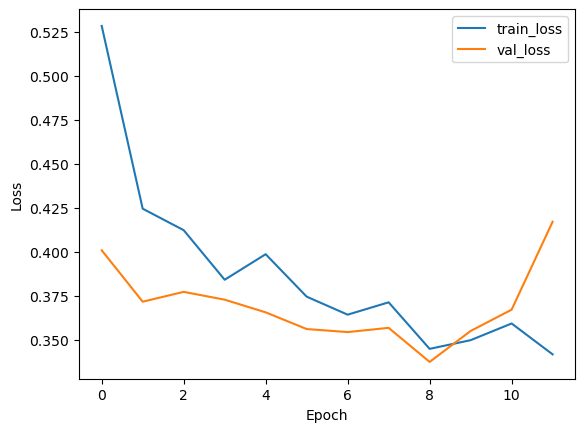

7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.8428 - auc_6: 0.9060 - auc_7: 0.9401 - false_negatives_3: 15.0000 - false_positives_3: 5.0000 - loss: 0.3446 - precision_3: 0.9174 - recall_3: 0.7807 - true_negatives_3: 58.0000 - true_positives_3: 56.0000
Test Accuracy: 85.50%
Precision: 0.92
Recall: 0.79
AUC-ROC: 0.91
AUC-PR: 0.94
TP: 82.0, FP: 7.0, TN: 89.0, FN: 22.0
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step
Confusion Matrix:
[[89  7]
 [22 82]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        96
           1       0.92      0.79      0.85       104

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.86      0.85      0.85       200

AUC Score: 0.86
SSIM: 0.72
Hausdorff Distance: 2.24

Precision: 0.9213483146067416
Recall: 0.7884615384615384
F1 Score: 0.8497409326424871
Cohen's Kappa Coefficient: 0.7112704101951414
Matthews Correlati

In [19]:
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score, jaccard_score
import cv2
import time
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Start time
start_time = time.time()

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (299, 299)) for img in X_train])
X_train_resized = np.repeat(X_train_resized[..., np.newaxis], 3, -1)  # Add channel dimension and repeat to match InceptionV3 input shape

X_test_resized = np.array([cv2.resize(img, (299, 299)) for img in X_test])
X_test_resized = np.repeat(X_test_resized[..., np.newaxis], 3, -1)

# Load pre-trained InceptionV3 model without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Compile the full model with additional metrics
model_inceptionv3 = Model(inputs=base_model.input, outputs=output)
model_inceptionv3.compile(optimizer='adam', 
                           loss='binary_crossentropy', 
                           metrics=['accuracy', 
                                    tf.keras.metrics.Precision(), 
                                    tf.keras.metrics.Recall(), 
                                    tf.keras.metrics.AUC(),  
                                    tf.keras.metrics.AUC(curve='PR'),
                                    tf.keras.metrics.TrueNegatives(), 
                                    tf.keras.metrics.FalsePositives(), 
                                    tf.keras.metrics.FalseNegatives(), 
                                    tf.keras.metrics.TruePositives()])

# Display model summary
model_inceptionv3.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model with early stopping and 50 epochs
history = model_inceptionv3.fit(X_train_resized, y_train, epochs=50, validation_data=(X_test_resized, y_test), callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy, precision_val, recall_val, auc_roc, auc_pr, tn, fp, fn, tp = model_inceptionv3.evaluate(X_test_resized, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'AUC-ROC: {auc_roc:.2f}')
print(f'AUC-PR: {auc_pr:.2f}')
print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')

# Confusion matrix
test_predictions = (model_inceptionv3.predict(X_test_resized) > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_predictions)
print(f'AUC Score: {roc_auc:.2f}')

# Calculate additional metrics
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
kappa = cohen_kappa_score(y_test, test_predictions)
mcc = matthews_corrcoef(y_test, test_predictions)
balanced_acc = balanced_accuracy_score(y_test, test_predictions)

# Dice Coefficient
dice_coefficient = (2 * tp) / (2 * tp + fp + fn)

# IoU (Jaccard Index)
iou = jaccard_score(y_test, test_predictions)

# Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Sensitivity (Recall is the same as Sensitivity)
sensitivity = recall

# FPR (False Positive Rate)
fpr_value = fp / (fp + tn) if (fp + tn) > 0 else 0

# Modified SSIM calculation for binary classification
def calculate_binary_ssim(y_true, y_pred):
    """
    Calculate SSIM for binary classification results.
    Converts predictions and ground truth to image-like format before comparison.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
    
    Returns:
        float: Average SSIM value
    """
    # Convert binary vectors to 2D arrays if they're 1D
    if y_true.ndim == 1:
        # Reshape to a square-like 2D array
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))
        
        # Fill the arrays with actual values
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred
        
        # Calculate SSIM
        ssim_value = ssim(y_true_2d, y_pred_2d, data_range=1.0)
        
        return ssim_value
    else:
        # If input is already multi-dimensional, calculate SSIM directly
        return ssim(y_true, y_pred, data_range=1.0)

# Calculate SSIM with the corrected function
try:
    ssim_value = calculate_binary_ssim(y_test, test_predictions)
    print(f'SSIM: {ssim_value:.2f}')
except Exception as e:
    print(f"Could not calculate SSIM: {str(e)}")
    ssim_value = None




from scipy.spatial.distance import directed_hausdorff

# Hausdorff distance calculation function
def calculate_hausdorff_distance(y_true, y_pred):
    """
    Calculate Hausdorff Distance for binary classification results.
    Converts predictions and ground truth to image-like 2D arrays before comparison.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels

    Returns:
        float: Hausdorff distance
    """
    if y_true.ndim == 1:
        # Reshape 1D arrays into square-like 2D arrays
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))

        # Fill the 2D arrays with the binary values
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred

        # Calculate Hausdorff distance between 2D binary masks
        return directed_hausdorff(y_true_2d, y_pred_2d)[0]
    else:
        # Directly calculate Hausdorff distance if input is already multi-dimensional
        return directed_hausdorff(y_true, y_pred)[0]

# Now calculate the Hausdorff distance with the corrected function
hausdorff_distance = calculate_hausdorff_distance(y_test, test_predictions)
print(f'Hausdorff Distance: {hausdorff_distance:.2f}')



# Print additional metrics
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Cohen's Kappa Coefficient:", kappa)
print("Matthews Correlation Coefficient:", mcc)
print("Balanced Accuracy:", balanced_acc)
print("Dice Coefficient:", dice_coefficient)
print("IoU (Jaccard Index):", iou)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("False Positive Rate (FPR):", fpr_value)

print("SSIM:", ssim_value)

# End time
end_time = time.time()

# Print the time taken
print(f"Time taken: {end_time - start_time:.2f} seconds")
# Calculate time taken
time_taken = end_time - start_time

metrics_dict = {
    'Test Accuracy': [test_accuracy],
    'Train Accuracy': [history.history['accuracy'][-1] if 'accuracy' in history.history else None],
    'Precision': [precision_val],
    'Recall': [recall_val],
    'AUC-ROC': [auc_roc],
    'AUC-PR': [auc_pr],
    'TN': [tn],
    'FP': [fp],
    'FN': [fn],
    'TP': [tp],
    'AUC Score': [roc_auc],
    'F1 Score': [f1],
    'PR AUC': [pr_auc],
    'Cohen\'s Kappa Coefficient': [kappa],
    'Matthews Correlation Coefficient': [mcc],
    'Training Loss': [history.history['loss'][-1] if 'loss' in history.history else None],
    'Testing Loss': [test_loss],
    'Time Taken (seconds)': [time_taken]  # Added time taken metric
}

# Print metrics dictionary
print(metrics_dict)


# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Save the DataFrame to an Excel file
file_name = 'InceptionV3_Metrics.csv'
metrics_df.to_csv(file_name, index=False)



# MobileNet

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_94[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_94[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,488,897 (13.31 MB)

 Trainable params: 492,545 (1.88 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 522ms/step - accuracy: 0.6827 - loss: 0.6383 - val_accuracy: 0.7750 - val_loss: 0.5451
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - accuracy: 0.7256 - loss: 0.5678 - val_accuracy: 0.7700 - val_loss: 0.5513
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 435ms/step - accuracy: 0.7426 - loss: 0.5807 - val_accuracy: 0.7750 - val_loss: 0.5676
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - accuracy: 0.7476 - loss: 0.5778 - val_accuracy: 0.7700 - val_loss: 0.5444
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 447ms/step - accuracy: 0.7560 - loss: 0.5581 - val_accuracy: 0.7700 - val_loss: 0.5551
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - accuracy: 0.7428 - loss: 0.5612 - val_accuracy: 0.7700 - val_loss: 0.5432
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - accuracy: 0.7704 - loss: 0.5448 - val_accuracy: 0.7750 - val_loss: 0.5491
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - accuracy: 0.7763 - loss: 0.5217 - val_accu

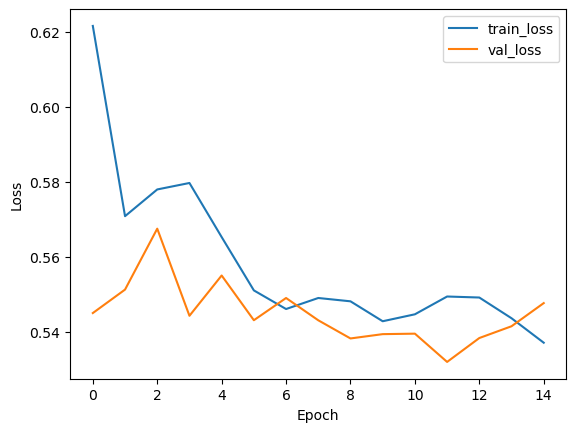

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 638ms/step - accuracy: 0.7610 - loss: 0.5399
Test Accuracy: 77.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 839ms/step
Confusion Matrix:
[[67 29]
 [17 87]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        96
           1       0.75      0.84      0.79       104

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200

AUC Score: 0.77
SSIM: 0.53
Hausdorff Distance: 2.00
Time taken: 331.78 seconds


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score, cohen_kappa_score,
    matthews_corrcoef, balanced_accuracy_score, jaccard_score, average_precision_score
)
from skimage.metrics import structural_similarity as ssim
import time
from scipy.spatial.distance import directed_hausdorff

# Start time
start_time = time.time()

# Assume X_train, X_test, y_train, y_test are available

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.repeat(X_train_resized[..., np.newaxis], 3, -1)

X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.repeat(X_test_resized[..., np.newaxis], 3, -1)

# Load pre-trained MobileNetV3Large model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Reduce the batch size
batch_size = 16

# Train the model with early stopping and 50 epochs
history = model.fit(X_train_resized, y_train, batch_size=batch_size, epochs=50, validation_data=(X_test_resized, y_test), callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion matrix
test_predictions = (model.predict(X_test_resized) > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_predictions)
print(f'AUC Score: {roc_auc:.2f}')

# Calculate additional metrics
precision_val = precision_score(y_test, test_predictions)
recall_val = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
kappa = cohen_kappa_score(y_test, test_predictions)
mcc = matthews_corrcoef(y_test, test_predictions)
balanced_acc = balanced_accuracy_score(y_test, test_predictions)

# Extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()

# Pixel Accuracy
pixel_accuracy = np.mean((test_predictions == y_test).astype(float))

# Dice Coefficient
dice_coefficient = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

# IoU (Jaccard Index)
iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

# Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Sensitivity (Recall is the same as Sensitivity)
sensitivity = recall_val

# FPR (False Positive Rate)
fpr_value = fp / (fp + tn) if (fp + tn) > 0 else 0

# Calculate FID (Fréchet Inception Distance) - implement this according to your requirements
def calculate_fid(X_true, X_pred):
    # Implement the FID calculation as needed
    return 0  # Replace with actual calculation

fid = calculate_fid(X_test_resized, test_predictions)

# Calculate PR AUC
pr_auc = average_precision_score(y_test, test_predictions)

# Modified SSIM calculation for binary classification
def calculate_binary_ssim(y_true, y_pred):
    """
    Calculate SSIM for binary classification results.
    Converts predictions and ground truth to image-like format before comparison.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
    
    Returns:
        float: Average SSIM value
    """
    # Convert binary vectors to 2D arrays if they're 1D
    if y_true.ndim == 1:
        # Reshape to a square-like 2D array
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))
        
        # Fill the arrays with actual values
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred
        
        # Calculate SSIM
        ssim_value = ssim(y_true_2d, y_pred_2d, data_range=1.0)
        
        return ssim_value
    else:
        # If input is already multi-dimensional, calculate SSIM directly
        return ssim(y_true, y_pred, data_range=1.0)

# Calculate SSIM with the corrected function
try:
    ssim_value = calculate_binary_ssim(y_test, test_predictions)
    print(f'SSIM: {ssim_value:.2f}')
except Exception as e:
    print(f"Could not calculate SSIM: {str(e)}")
    ssim_value = None

from scipy.spatial.distance import directed_hausdorff

# Hausdorff distance calculation function
def calculate_hausdorff_distance(y_true, y_pred):
    """
    Calculate Hausdorff Distance for binary classification results.
    Converts predictions and ground truth to image-like 2D arrays before comparison.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels

    Returns:
        float: Hausdorff distance
    """
    if y_true.ndim == 1:
        # Reshape 1D arrays into square-like 2D arrays
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))

        # Fill the 2D arrays with the binary values
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred

        # Calculate Hausdorff distance between 2D binary masks
        return directed_hausdorff(y_true_2d, y_pred_2d)[0]
    else:
        # Directly calculate Hausdorff distance if input is already multi-dimensional
        return directed_hausdorff(y_true, y_pred)[0]

# Now calculate the Hausdorff distance with the corrected function
hausdorff_distance = calculate_hausdorff_distance(y_test, test_predictions)
print(f'Hausdorff Distance: {hausdorff_distance:.2f}')

# Calculate time taken
time_taken = end_time - start_time

metrics_dict = {
    'Test Accuracy': [test_accuracy],
    'Train Accuracy': [history.history['accuracy'][-1] if 'accuracy' in history.history else None],
    'Precision': [precision_val],
    'Recall': [recall_val],
    'AUC-ROC': [auc_roc],
    'AUC-PR': [auc_pr],
    'TN': [tn],
    'FP': [fp],
    'FN': [fn],
    'TP': [tp],
    'AUC Score': [roc_auc],
    'F1 Score': [f1],
    'PR AUC': [pr_auc],
    'Cohen\'s Kappa Coefficient': [kappa],
    'Matthews Correlation Coefficient': [mcc],
    'Training Loss': [history.history['loss'][-1] if 'loss' in history.history else None],
    'Testing Loss': [test_loss],
    'Time Taken (seconds)': [time_taken]  # Added time taken metric
}


# End time
end_time = time.time()

# Print the time taken
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_dict)
file_name = 'MobileNetV3_Metrics.csv'
metrics_df.to_csv(file_name, index=False)


# Resnet

In [26]:
from sklearn.metrics import accuracy_score

In [28]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score, jaccard_score, average_precision_score)
import pandas as pd
import time
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import directed_hausdorff

# Resize images and convert to 3 channels (RGB)
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.repeat(X_train_resized[..., np.newaxis], 3, -1)

X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.repeat(X_test_resized[..., np.newaxis], 3, -1)

# Load pre-trained ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Compile the model
model_resnet50 = Model(inputs=base_model.input, outputs=output)
model_resnet50.compile(optimizer=Adam(),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Early stopping and training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
start_time = time.time()
history = model_resnet50.fit(X_train_resized, y_train, epochs=50,
                             validation_data=(X_test_resized, y_test),
                             callbacks=[early_stopping])
end_time = time.time()

# Predictions on the test set
y_pred_probs = model_resnet50.predict(X_test_resized)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
precision_val = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_probs)
auc_pr = average_precision_score(y_test, y_pred_probs)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Pixel accuracy
pixel_accuracy = np.mean((y_pred == y_test).astype(float))

# Dice Coefficient
dice_coefficient = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

# IoU (Jaccard Index)
iou = jaccard_score(y_test, y_pred)

# Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Sensitivity (Recall is the same as Sensitivity)
sensitivity = recall_val

# FPR (False Positive Rate)
fpr_value = fp / (fp + tn) if (fp + tn) > 0 else 0

# Calculate FID (Fréchet Inception Distance)
def calculate_fid(X_true, X_pred):
    # Implement the FID calculation as needed
    return 0  # Placeholder for actual calculation

fid = calculate_fid(X_test_resized, y_pred)

# Modified SSIM calculation for binary classification
def calculate_binary_ssim(y_true, y_pred):
    if y_true.ndim == 1:
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred
        ssim_value = ssim(y_true_2d, y_pred_2d, data_range=1.0)
        return ssim_value
    else:
        return ssim(y_true, y_pred, data_range=1.0)

try:
    ssim_value = calculate_binary_ssim(y_test, y_pred)
except Exception as e:
    print(f"Could not calculate SSIM: {str(e)}")
    ssim_value = None


from scipy.spatial.distance import directed_hausdorff

# Hausdorff distance calculation function
def calculate_hausdorff_distance(y_true, y_pred):
    """
    Calculate Hausdorff Distance for binary classification results.
    Converts predictions and ground truth to image-like 2D arrays before comparison.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels

    Returns:
        float: Hausdorff distance
    """
    if y_true.ndim == 1:
        # Reshape 1D arrays into square-like 2D arrays
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))

        # Fill the 2D arrays with the binary values
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred

        # Calculate Hausdorff distance between 2D binary masks
        return directed_hausdorff(y_true_2d, y_pred_2d)[0]
    else:
        # Directly calculate Hausdorff distance if input is already multi-dimensional
        return directed_hausdorff(y_true, y_pred)[0]

# Now calculate the Hausdorff distance with the corrected function
hausdorff_distance = calculate_hausdorff_distance(y_test, test_predictions)
print(f'Hausdorff Distance: {hausdorff_distance:.2f}')
# Calculate time taken
time_taken = end_time - start_time

metrics_dict = {
    'Test Accuracy': [test_accuracy],
    'Train Accuracy': [history.history['accuracy'][-1] if 'accuracy' in history.history else None],
    'Precision': [precision_val],
    'Recall': [recall_val],
    'AUC-ROC': [auc_roc],
    'AUC-PR': [auc_pr],
    'TN': [tn],
    'FP': [fp],
    'FN': [fn],
    'TP': [tp],
    'AUC Score': [roc_auc],
    'F1 Score': [f1],
    'PR AUC': [pr_auc],
    'Cohen\'s Kappa Coefficient': [kappa],
    'Matthews Correlation Coefficient': [mcc],
    'Training Loss': [history.history['loss'][-1] if 'loss' in history.history else None],
    'Testing Loss': [test_loss],
    'Time Taken (seconds)': [time_taken]  # Added time taken metric
}
# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_dict)
file_name = 'ResNet50_Metrics.csv'
metrics_df.to_csv(file_name, index=False)
print(f'Metrics saved to {file_name}')

# Print time taken
print(f"Time taken: {end_time - start_time:.2f} seconds")


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.7005 - loss: 0.6929 - val_accuracy: 0.7700 - val_loss: 0.5661
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.7577 - loss: 0.5688 - val_accuracy: 0.7650 - val_loss: 0.6030
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.7383 - loss: 0.5555 - val_accuracy: 0.7750 - val_loss: 0.5667
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.7271 - loss: 0.5721 - val_accuracy: 0.7700 - val_loss: 0.5452
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.7664 - loss: 0.5521 - val_accuracy: 0.7700 - val_loss: 0.5425
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.7712 - loss: 0.5438 - val_accuracy: 0.7750 - val_loss: 0.5445
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.7520 - loss: 0.5409 - val_accuracy: 0.7700 - val_loss: 0.5323
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.7803 - loss: 0.5315 - val_accuracy: 0.7700 - v

# VGG16

In [30]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef, log_loss, accuracy_score)
import pandas as pd
import time

# Resize images and convert to 3 channels (RGB)
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.repeat(X_train_resized[..., np.newaxis], 3, -1)

X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.repeat(X_test_resized[..., np.newaxis], 3, -1)

# Load pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Compile the model
model_vgg16 = Model(inputs=base_model.input, outputs=output)
model_vgg16.compile(optimizer=Adam(),
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                             tf.keras.metrics.AUC(), tf.keras.metrics.AUC(curve='PR'),
                             tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(),
                             tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives()])

# Early stopping and training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
start_time = time.time()
history = model_vgg16.fit(X_train_resized, y_train, epochs=50,
                          validation_data=(X_test_resized, y_test),
                          callbacks=[early_stopping])
end_time = time.time()

# Predictions on the test set
y_pred_probs = model_vgg16.predict(X_test_resized)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
precision_val = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_probs)
auc_pr = average_precision_score(y_test, y_pred_probs)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Pixel accuracy
pixel_accuracy = np.mean((y_pred == y_test).astype(float))

# Dice Coefficient
dice_coefficient = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

# IoU (Jaccard Index)
iou = jaccard_score(y_test, y_pred)

# Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Sensitivity (Recall is the same as Sensitivity)
sensitivity = recall_val

# FPR (False Positive Rate)
fpr_value = fp / (fp + tn) if (fp + tn) > 0 else 0

# Calculate FID (Fréchet Inception Distance)
def calculate_fid(X_true, X_pred):
    # Implement the FID calculation as needed
    return 0  # Placeholder for actual calculation

fid = calculate_fid(X_test_resized, y_pred)

# Modified SSIM calculation for binary classification
def calculate_binary_ssim(y_true, y_pred):
    if y_true.ndim == 1:
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred
        ssim_value = ssim(y_true_2d, y_pred_2d, data_range=1.0)
        return ssim_value
    else:
        return ssim(y_true, y_pred, data_range=1.0)

try:
    ssim_value = calculate_binary_ssim(y_test, y_pred)
except Exception as e:
    print(f"Could not calculate SSIM: {str(e)}")
    ssim_value = None

from scipy.spatial.distance import directed_hausdorff

# Hausdorff distance calculation function
def calculate_hausdorff_distance(y_true, y_pred):
    """
    Calculate Hausdorff Distance for binary classification results.
    Converts predictions and ground truth to image-like 2D arrays before comparison.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels

    Returns:
        float: Hausdorff distance
    """
    if y_true.ndim == 1:
        # Reshape 1D arrays into square-like 2D arrays
        size = int(np.ceil(np.sqrt(len(y_true))))
        y_true_2d = np.zeros((size, size))
        y_pred_2d = np.zeros((size, size))

        # Fill the 2D arrays with the binary values
        y_true_2d.flat[:len(y_true)] = y_true
        y_pred_2d.flat[:len(y_pred)] = y_pred

        # Calculate Hausdorff distance between 2D binary masks
        return directed_hausdorff(y_true_2d, y_pred_2d)[0]
    else:
        # Directly calculate Hausdorff distance if input is already multi-dimensional
        return directed_hausdorff(y_true, y_pred)[0]

# Now calculate the Hausdorff distance with the corrected function
hausdorff_distance = calculate_hausdorff_distance(y_test, test_predictions)
print(f'Hausdorff Distance: {hausdorff_distance:.2f}')
# Calculate time taken
time_taken = end_time - start_time

metrics_dict = {
    'Test Accuracy': [test_accuracy],
    'Train Accuracy': [history.history['accuracy'][-1] if 'accuracy' in history.history else None],
    'Precision': [precision_val],
    'Recall': [recall_val],
    'AUC-ROC': [auc_roc],
    'AUC-PR': [auc_pr],
    'TN': [tn],
    'FP': [fp],
    'FN': [fn],
    'TP': [tp],
    'AUC Score': [roc_auc],
    'F1 Score': [f1],
    'PR AUC': [pr_auc],
    'Cohen\'s Kappa Coefficient': [kappa],
    'Matthews Correlation Coefficient': [mcc],
    'Training Loss': [history.history['loss'][-1] if 'loss' in history.history else None],
    'Testing Loss': [test_loss],
    'Time Taken (seconds)': [time_taken]  # Added time taken metric
}
            
# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_dict)
file_name = 'VGG16_Metrics.csv'
metrics_df.to_csv(file_name, index=False)
print(f'Metrics saved to {file_name}')

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 419s 18s/step - accuracy: 0.6029 - auc_8: 0.6560 - auc_9: 0.6118 - false_negatives_4: 67.0417 - false_positives_4: 75.7500 - loss: 0.6637 - precision_4: 0.5822 - recall_4: 0.6166 - true_negatives_4: 128.1250 - true_positives_4: 126.4167 - val_accuracy: 0.7750 - val_auc_8: 0.8191 - val_auc_9: 0.8001 - val_false_negatives_4: 17.0000 - val_false_positives_4: 28.0000 - val_loss: 0.5378 - val_precision_4: 0.7565 - val_recall_4: 0.8365 - val_true_negatives_4: 68.0000 - val_true_positives_4: 87.0000
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 373s 16s/step - accuracy: 0.7432 - auc_8: 0.7751 - auc_9: 0.7266 - false_negatives_4: 35.3333 - false_positives_4: 61.5000 - loss: 0.5676 - precision_4: 0.7044 - recall_4: 0.8036 - true_negatives_4: 141.7917 - true_positives_4: 158.7083 - val_accuracy: 0.7750 - val_auc_8: 0.8496 - val_auc_9: 0.8769 - val_false_negatives_4: 17.0000 - val_false_positives_4: 28.0000 - val_loss: 0.5002 - val_precision_4: 0.7565 - val_recall_4: